## OBJECTIVE : 
To implement simple GAN. 
Paper : https://arxiv.org/abs/1406.2661

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l1_l2 as l1l2
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
K.set_image_dim_ordering('th')

np.random.seed(1000)

randomDim = 100

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

In [4]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [5]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total para

In [6]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
__________

In [7]:
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """


In [8]:
dLosses = []
gLosses = []

In [15]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images_gan/gan_loss_epoch_%d.png' % epoch)
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images_gan/gan_generated_image_epoch_%d.png' % epoch)

def saveModels(epoch):
    generator.save('models_gan/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models_gan/gan_discriminator_epoch_%d.h5' % epoch)

In [10]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    batchCount = int(batchCount)
    print ('Batches per epoch:', batchCount)
    plotGeneratedImages(0)
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9494982890116420741
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286970368
locality {
  bus_id: 1
}
incarnation: 18279179406466069192
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


Epochs: 100
Batch size: 1024
Batches per epoch: 58


  3%|▎         | 2/58 [00:00<00:05, 10.47it/s]

--------------- Epoch 1 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 2 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.70it/s]

--------------- Epoch 3 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.64it/s]

--------------- Epoch 4 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.66it/s]

--------------- Epoch 5 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.76it/s]

--------------- Epoch 6 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.58it/s]

--------------- Epoch 7 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.70it/s]

--------------- Epoch 8 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.56it/s]

--------------- Epoch 9 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.69it/s]

--------------- Epoch 10 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 11 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.73it/s]

--------------- Epoch 12 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.69it/s]

--------------- Epoch 13 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.58it/s]

--------------- Epoch 14 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.59it/s]

--------------- Epoch 15 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.49it/s]

--------------- Epoch 16 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.60it/s]

--------------- Epoch 17 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.55it/s]

--------------- Epoch 18 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.59it/s]

--------------- Epoch 19 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.55it/s]

--------------- Epoch 20 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.75it/s]

--------------- Epoch 21 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.60it/s]

--------------- Epoch 22 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.55it/s]

--------------- Epoch 23 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.61it/s]

--------------- Epoch 24 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.65it/s]

--------------- Epoch 25 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.71it/s]

--------------- Epoch 26 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.54it/s]

--------------- Epoch 27 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.51it/s]

--------------- Epoch 28 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.64it/s]

--------------- Epoch 29 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.65it/s]

--------------- Epoch 30 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 31 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 32 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.61it/s]

--------------- Epoch 33 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 34 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.75it/s]

--------------- Epoch 35 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.45it/s]

--------------- Epoch 36 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.59it/s]

--------------- Epoch 37 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.44it/s]

--------------- Epoch 38 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.62it/s]

--------------- Epoch 39 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.59it/s]

--------------- Epoch 40 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.51it/s]

--------------- Epoch 41 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.55it/s]

--------------- Epoch 42 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.71it/s]

--------------- Epoch 43 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.58it/s]

--------------- Epoch 44 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.70it/s]

--------------- Epoch 45 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.54it/s]

--------------- Epoch 46 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.66it/s]

--------------- Epoch 47 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 48 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.62it/s]

--------------- Epoch 49 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.59it/s]

--------------- Epoch 50 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 51 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 52 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.61it/s]

--------------- Epoch 53 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.74it/s]

--------------- Epoch 54 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.56it/s]

--------------- Epoch 55 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.59it/s]

--------------- Epoch 56 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.67it/s]

--------------- Epoch 57 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 58 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.66it/s]

--------------- Epoch 59 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.50it/s]

--------------- Epoch 60 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.66it/s]

--------------- Epoch 61 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 62 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.65it/s]

--------------- Epoch 63 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.66it/s]

--------------- Epoch 64 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.62it/s]

--------------- Epoch 65 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.57it/s]

--------------- Epoch 66 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.67it/s]

--------------- Epoch 67 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.60it/s]

--------------- Epoch 68 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.73it/s]

--------------- Epoch 69 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.67it/s]

--------------- Epoch 70 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.62it/s]

--------------- Epoch 71 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.58it/s]

--------------- Epoch 72 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.67it/s]

--------------- Epoch 73 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.68it/s]

--------------- Epoch 74 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.65it/s]

--------------- Epoch 75 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.68it/s]

--------------- Epoch 76 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.52it/s]

--------------- Epoch 77 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.44it/s]

--------------- Epoch 78 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.64it/s]

--------------- Epoch 79 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.74it/s]

--------------- Epoch 80 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.62it/s]

--------------- Epoch 81 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.61it/s]

--------------- Epoch 82 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.62it/s]

--------------- Epoch 83 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.65it/s]

--------------- Epoch 84 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.56it/s]

--------------- Epoch 85 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.65it/s]

--------------- Epoch 86 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.40it/s]

--------------- Epoch 87 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.70it/s]

--------------- Epoch 88 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.70it/s]

--------------- Epoch 89 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.65it/s]

--------------- Epoch 90 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.63it/s]

--------------- Epoch 91 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.75it/s]

--------------- Epoch 92 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.63it/s]

--------------- Epoch 93 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.64it/s]

--------------- Epoch 94 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.63it/s]

--------------- Epoch 95 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.66it/s]

--------------- Epoch 96 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.40it/s]

--------------- Epoch 97 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.64it/s]

--------------- Epoch 98 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.72it/s]

--------------- Epoch 99 ---------------


  3%|▎         | 2/58 [00:00<00:05, 10.72it/s]

--------------- Epoch 100 ---------------


100%|██████████| 58/58 [00:05<00:00, 10.61it/s]


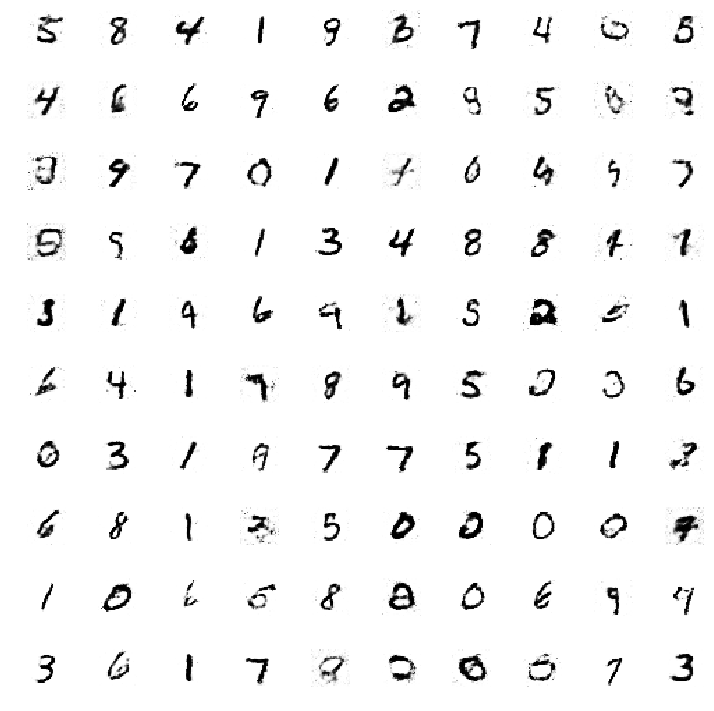

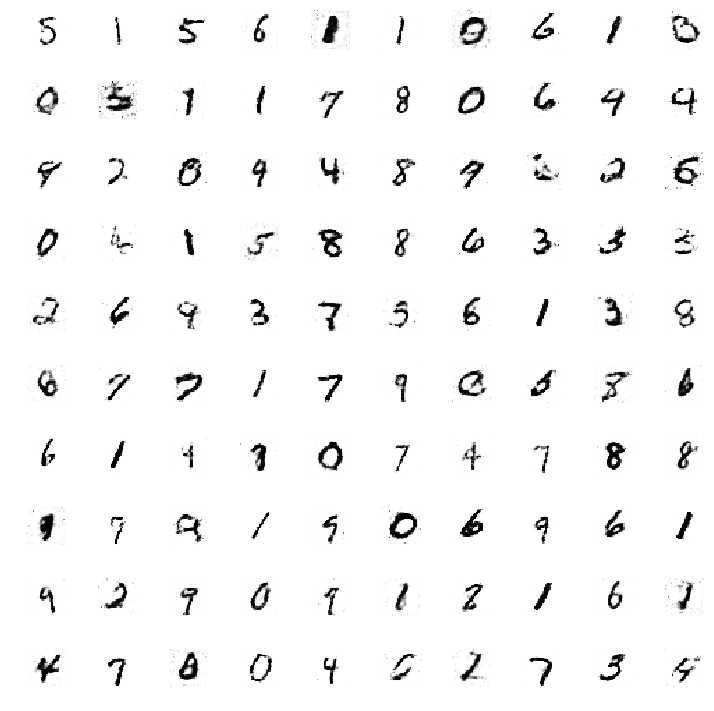

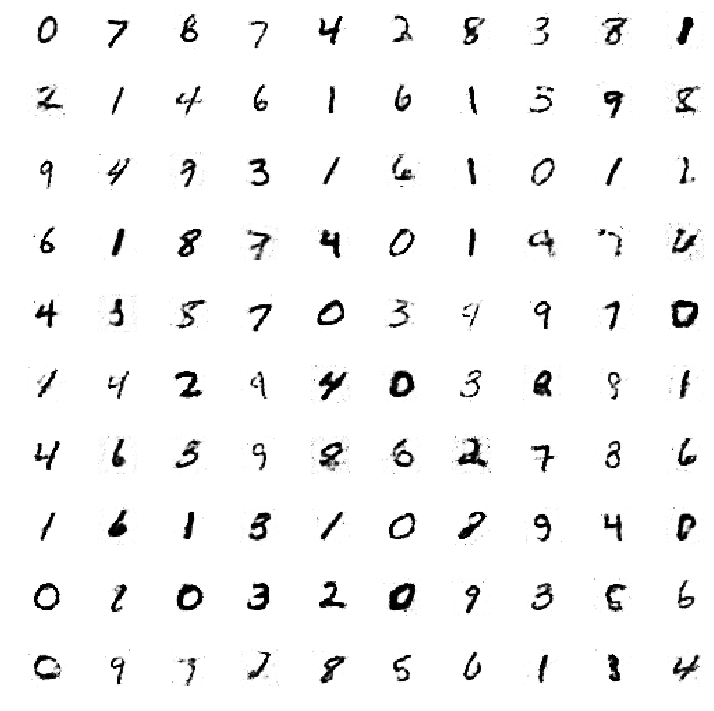

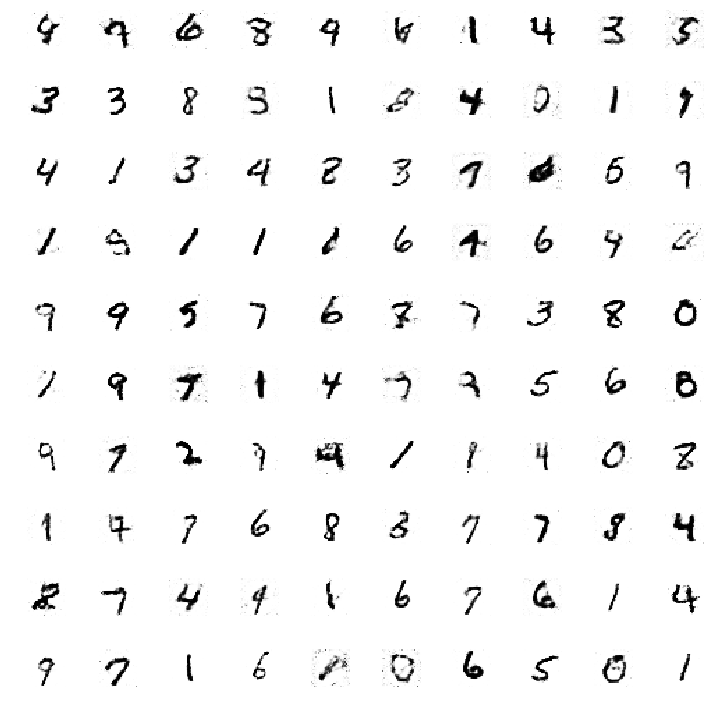

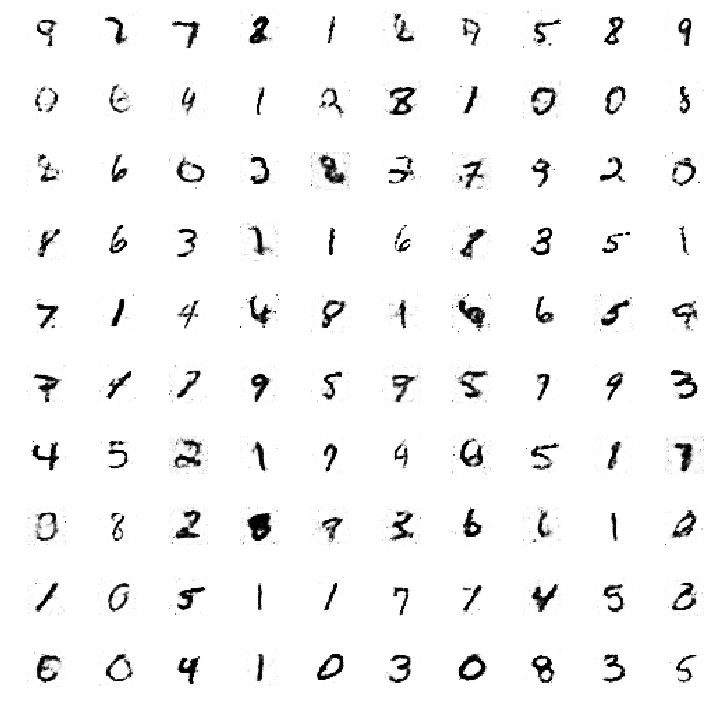

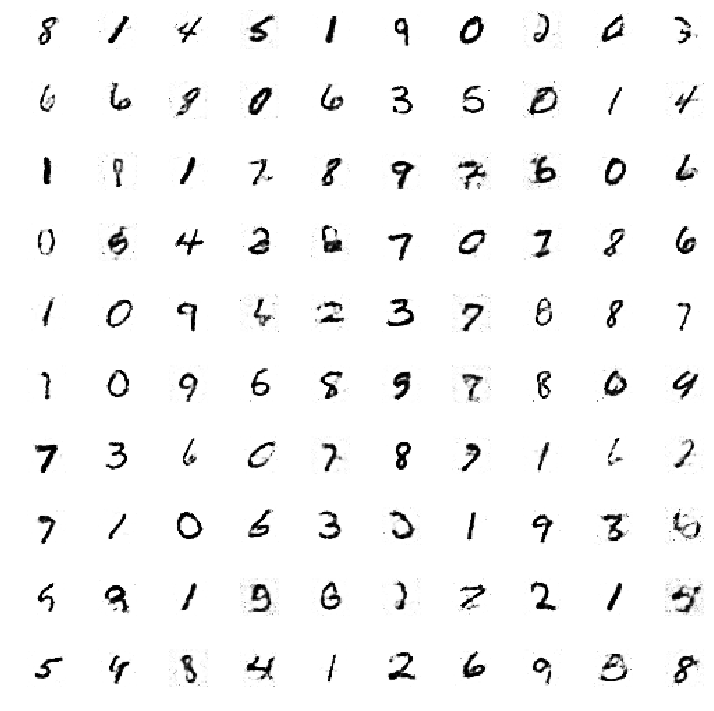

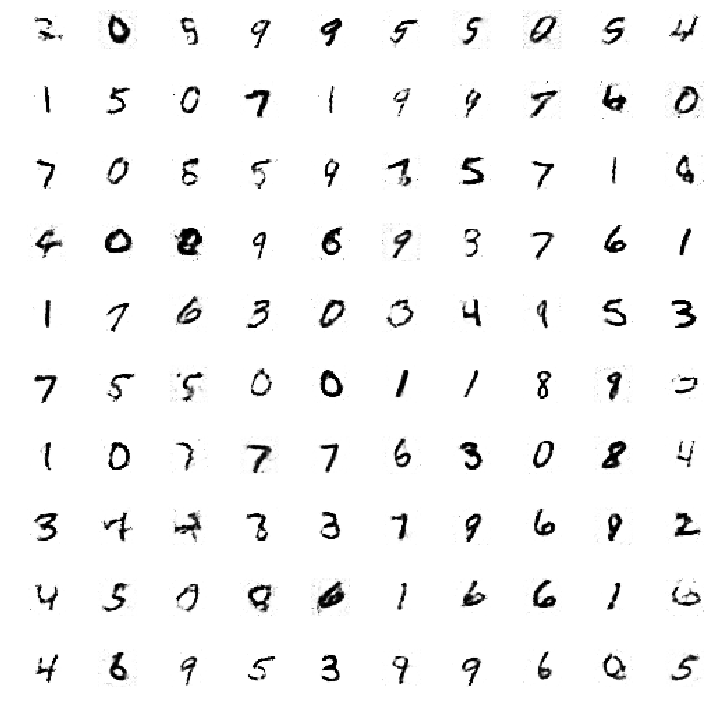

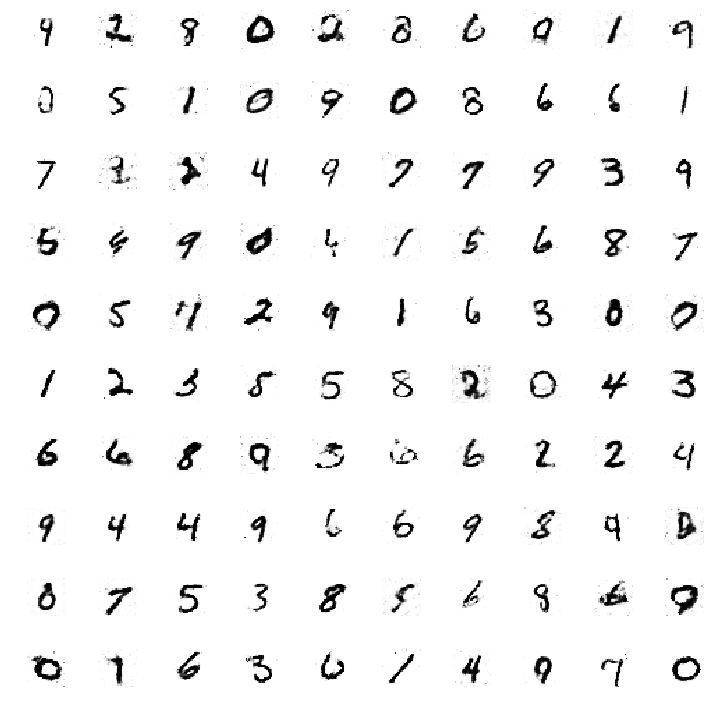

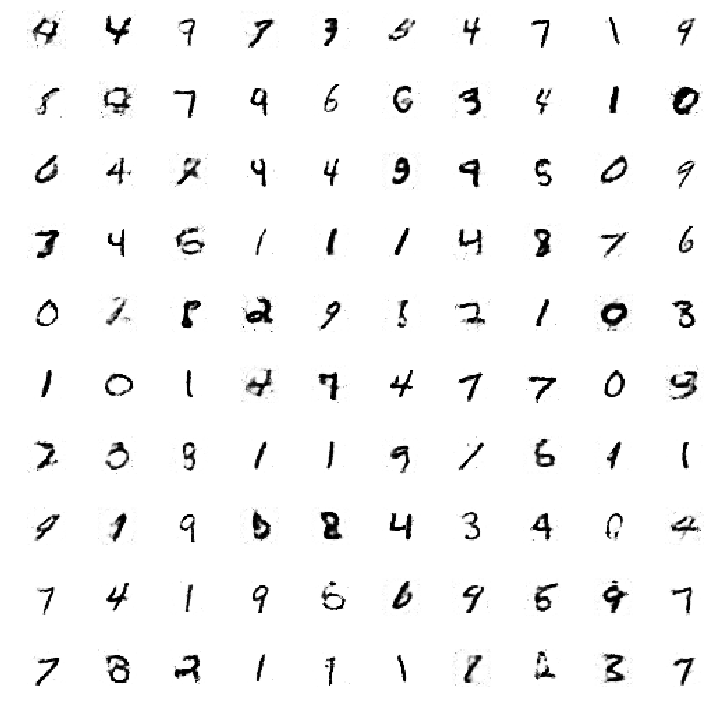

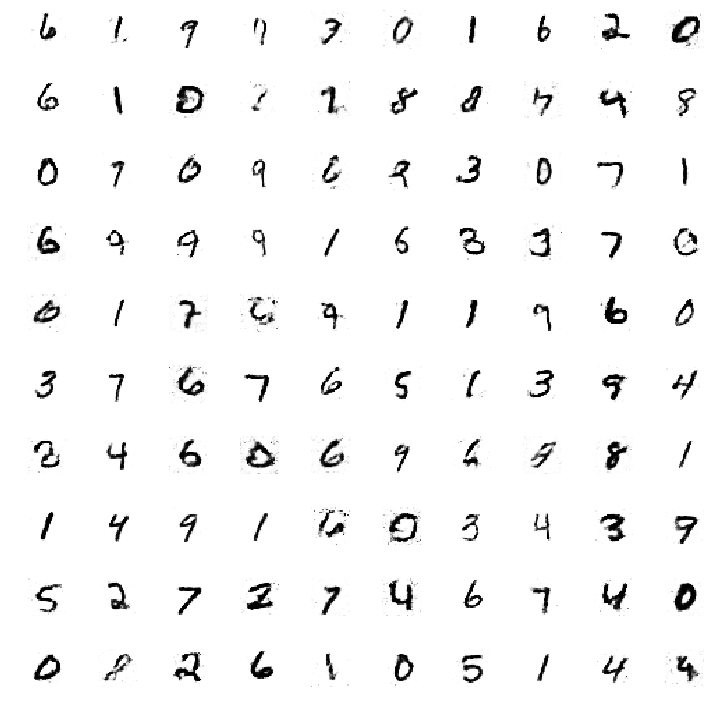

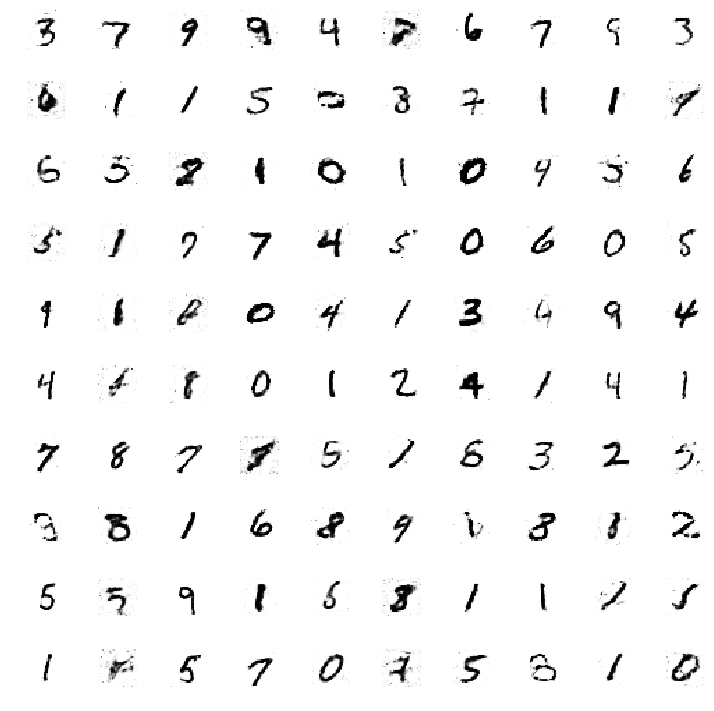

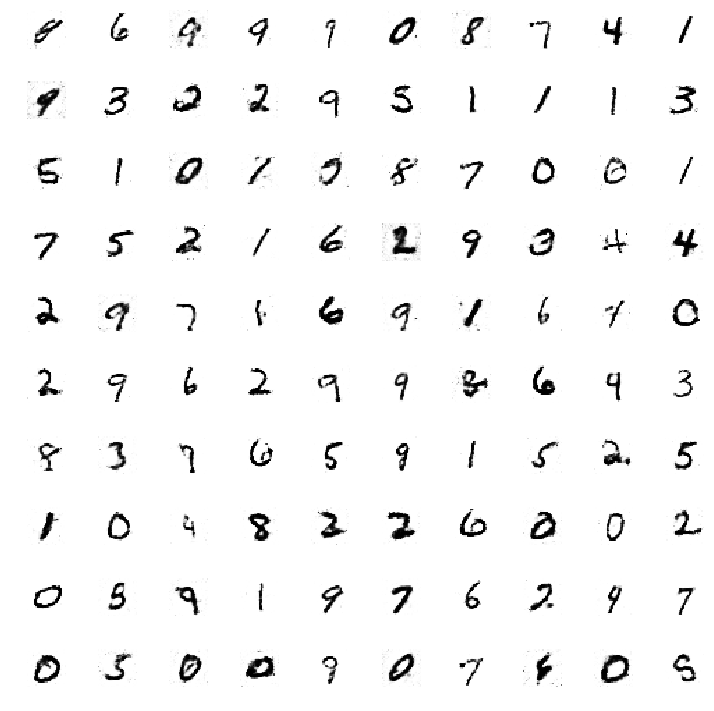

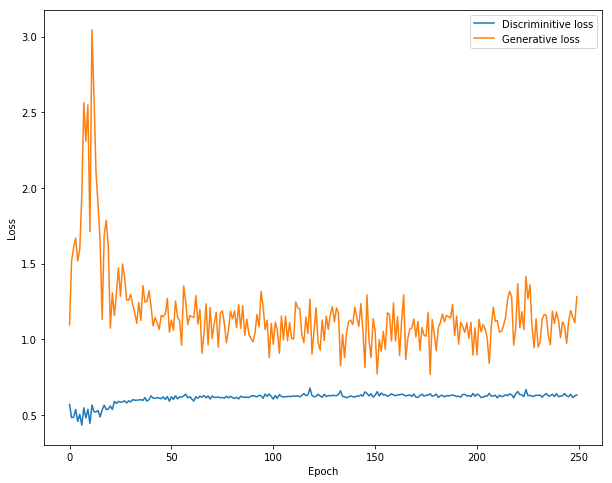

In [16]:
train(100,1024)